In [1]:
import math
import pandas as pd
import pyarrow
import fastparquet 

import os
import configparser
import datetime as dt
from datetime import datetime
from os.path import exists
import time
from pytimeparse.timeparse import timeparse

import folium
from random import randint

import shapely
from shapely.geometry import Point, Polygon, LineString, GeometryCollection
from shapely.ops import nearest_points
from pyproj import Geod
import numpy as np

from rdp import rdp
import similaritymeasures

In [2]:
# Method to read config file settings
def read_config(Config_File):
    config = configparser.ConfigParser()
    config.read(Config_File)
    return config

configurations = read_config("configurations.ini")

In [3]:
# LOAD NEEDED DATA

In [4]:
# Load RT data (gtfs_data)

In [5]:
rt_gtfs_data = pd.read_parquet('data\kh_transitview.parquet')
rt_gtfs_data = rt_gtfs_data.sort_values(by = ['file'])
rt_gtfs_data.head(5)

,BlockID,Direction,Offset,Offset_sec,VehicleID,destination,estimated_seat_availability,file,heading,label,lat,late,lng,next_stop_id,next_stop_name,next_stop_sequence,original_late,route,timestamp,trip
0,1081,SouthBound,1,10,8664,Frankford Transportation Center,NOT_AVAILABLE,2022-09-01,210,8664,40.093037,3,-75.017159,21945.0,Roosevelt Blvd & Plaza Dr - FS,71.0,3,14,2022-09-01 04:00:04+00:00,87728
128,5391,WestBound,1,7,7381,35th-Allegheny,NOT_AVAILABLE,2022-09-01,270,7381,40.001133,-2,-75.148354,20599.0,Allegheny Av & 5th St,27.0,-2,60,2022-09-01 04:00:04+00:00,75616
129,5436,NorthBound,1,27,7403,27th-Allegheny,NOT_AVAILABLE,2022-09-01,360,7403,39.978828,1,-75.182526,14942.0,29th St & Thompson St,44.0,2,48,2022-09-01 04:00:04+00:00,70324
130,5439,SouthBound,0,4,7412,Front-Market,NOT_AVAILABLE,2022-09-01,105,7412,39.949955,0,-75.142204,NaN,None,NaN,-2,48,2022-09-01 04:00:04+00:00,70182
131,5441,SouthBound,1,22,7319,Front-Market,NOT_AVAILABLE,2022-09-01,180,7319,39.989803,-1,-75.180038,30270.0,29th St & Huntingdon St,8.0,-1,48,2022-09-01 04:00:04+00:00,70183


In [6]:
rt_gtfs_data.dtypes

BlockID                                      int64
Direction                                   object
Offset                                       int64
Offset_sec                                   int64
VehicleID                                    int64
destination                                 object
estimated_seat_availability                 object
file                                datetime64[ns]
heading                                      int64
label                                        int64
lat                                        float64
late                                         int64
lng                                        float64
next_stop_id                               float64
next_stop_name                              object
next_stop_sequence                         float64
original_late                                int64
route                                       object
timestamp                      datetime64[ns, UTC]
trip                           

In [7]:
# Load Schedule Trips Data (trips_data)

In [8]:
sched_folder = 'sch_gtfs\\schedule_v202209101'

In [9]:
trips_f = sched_folder + '\\' + 'trips.txt'
trips_data = pd.read_csv(trips_f)
trips_data.head()

,route_id,service_id,trip_id,trip_headsign,block_id,direction_id,shape_id
0,1,10,87152,Decatur-Drummond,1003,0,275147
1,1,10,87153,Parx Casino,2151,0,275145
2,1,10,87154,Parx Casino via Decatur-Drummond,2155,0,275152
3,1,10,87155,Decatur-Drummond,1426,0,275151
4,1,10,87156,Parx Casino via Decatur-Drummond,2153,0,275152


In [10]:
# Load Schedule Shapes Data (shapes_data)

In [11]:
shapes_f = sched_folder + '\\' + 'shapes.txt'
shapes_data = pd.read_csv(shapes_f)
shapes_data.head()

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence
0,275145,40.105486,-75.000047,1072
1,275145,40.110772,-74.992364,1097
2,275145,40.112407,-74.989999,1104
3,275145,40.052940,-75.049911,953
4,275145,40.011494,-75.200398,467


In [12]:
# Load Schedule stops Data (stops_data)

In [13]:
stops_f = sched_folder + '\\' + 'stop_times.txt'
stops_data = pd.read_csv(stops_f)
stops_data.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence
0,33584,07:14:00,07:14:00,31294,1
1,33584,07:14:00,07:14:00,20610,2
2,33584,07:15:00,07:15:00,20611,3
3,33584,07:16:00,07:16:00,20612,4
4,33584,07:18:00,07:18:00,20613,5


In [14]:
###############################################################################
###############################################################################
###############################################################################

In [15]:
# Function to return schedule start/end times and first/last stop_ids of a trip_id
def get_sched_stop_times(trip_id):
    
    data = stops_data.loc[stops_data['trip_id'] == trip_id]
    
    if not data.empty:
        data = data.sort_values(by=['stop_sequence'])
        data1 = data.iloc[0]
        data2 = data.iloc[-1]
    
        return [data1['departure_time'], data1['stop_id'], data1['stop_sequence'],\
                data2['arrival_time'], data2['stop_id'], data2['stop_sequence']]
    
    else:
        return ['NA']

In [16]:
# Function to return schedule shape of a shape_id
def get_sched_shape(shape_id):
    
    data = shapes_data.loc[shapes_data['shape_id'] == shape_id]
    data = data.sort_values(by=['shape_pt_sequence'])
    data = list(zip(data.shape_pt_lat, data.shape_pt_lon))
    
    if len(data) > 1:
        return data
    else:
        return ['NA']

In [17]:
# Function to return schedule route_id, trip_id, shape_id, shapes for a given route list
def get_sched_route_gtfs(routes):

    data = pd.DataFrame(columns=['route_id', 'trip_id', 'sch_shape_id', 'sch_dep_time', 'sch_first_stop_id',
                                 'sch_first_stop_seq', 'sch_arr_time','sch_last_stop_id', 'sch_last_stop_seq',
                                 'sch_shape', 'rt_shape'])
    
    i = 0 #output DF index
    
    for route_id in routes:
        # for route, get all trips and keep needed columns
        trip = trips_data.loc[trips_data['route_id'] == route_id]
        trip = trip[['route_id', 'trip_id', 'shape_id']]

        # iterate over trips
        for index, row in trip.iterrows():
            # get trip stop and shape information
            stops = get_sched_stop_times(row['trip_id'])
            sched_shape = get_sched_shape(row['shape_id'])
            
            # if stop and shape info found add trip to output
            if stops[0] != 'NA' and sched_shape[0] != 'NA':
                
                data.at[i, 'route_id'] = row['route_id']
                data.at[i, 'trip_id'] = row['trip_id']
                data.at[i, 'sch_shape_id'] = row['shape_id']
                data.at[i, 'sch_dep_time'] = stops[0]
                data.at[i, 'sch_first_stop_id'] = stops[1]
                data.at[i, 'sch_first_stop_seq'] = stops[2]
                data.at[i, 'sch_arr_time'] = stops[3]
                data.at[i, 'sch_last_stop_id'] = stops[4]
                data.at[i, 'sch_last_stop_seq'] = stops[5]
                
                data.at[i, 'sch_shape'] = sched_shape
                
                i += 1
                
    data = data.astype({"route_id":'str', "trip_id":'Int64', "sch_shape_id":'Int64', "sch_dep_time":'str',
                        "sch_first_stop_id":'Int64', "sch_first_stop_seq":'Int64', "sch_arr_time":'str',
                        "sch_last_stop_id":'Int64', "sch_last_stop_seq":'Int64'}) 
        
    return data

In [18]:
def get_rt_shape(data):

    shape = data.sort_values(by = ['file'])
    shape = list(zip(shape.lat, shape.lng))
    
    # only return RT shapes that have more than 1 point
    if len(shape) > 1:
        return shape
    else:
        return 'NA'

In [19]:
def get_rt_gtfs(trip_id, sched_dep_dt, sched_first_stop_id, sched_arr_dt, sch_last_stop_id):
    
    # WILL EXCLUDE ALL TRIPS THAT DON'T START AT SCHEDULED STOP ID
    
    # look for RT data starting 5 minutes before sched departure, and arriving max 3 hours after sched arrival
    minus_delta = dt.timedelta(minutes=5)
    plus_delta = dt.timedelta(hours=3)
    
    data = rt_gtfs_data.loc[(rt_gtfs_data['file'] >= sched_dep_dt - minus_delta) & (rt_gtfs_data['file'] <= sched_arr_dt + plus_delta) &\
                            (rt_gtfs_data['trip'] == trip_id)]
    # exclude RT trips that have only 1 coordinate 
    if len(data.index) >= 2:
        data = data.sort_values(by=['file'])
        
        # drop all early feed updates where next stop id = sched_first_stop_id, except last one
        # this should eliminate feed updates before trip starts
        prev_index = -9        
        for index, row in data.iterrows():
            if row['next_stop_id'] == sched_first_stop_id and prev_index == -9:
                prev_index = index
            elif row['next_stop_id'] == sched_first_stop_id and prev_index != -9:
                data = data.drop([prev_index])
                prev_index = index
            else:
                break
                
        # if route still has more than 1 coordinate
        if len(data.index) >= 2:
            # keep only one feed update after last stop where next stop id is NaN
            # this should drop feed updates after bus arrives at last scheduled stop
            for index, row in data.iterrows():
                if row['next_stop_id'] == sch_last_stop_id:
                    if len(data.index) > index + 1:
                        if math.isnan(data.iloc[index+1]['next_stop_id']):
                            data = data.loc[:index+1]
            
#            while (math.isnan(data.iloc[-1]['next_stop_id'])):
#                if math.isnan(data.iloc[-2]['next_stop_id']):
#                    data = data[:-1]
#                else:
#                    break

            # if more than 1 coordinate in trip remains then
            if len(data.index) >= 2:
                # take first and before last feed updates to get first/last dep/arr info
                data1 = data.iloc[0] 
                data2 = data.iloc[-2]

                # get the RT shape
                rt_shape = get_rt_shape(data)

                if rt_shape != 'NA':
                    return[data1['Direction'], data1['VehicleID'], data1['file'], data1['next_stop_id'], data1['next_stop_sequence'],
                                                                   data2['file'], data2['next_stop_id'], data2['next_stop_sequence'], rt_shape]
                else:
                    return['NA']
            else:
                return['NA']
        else:
            return['NA']
    else:
        return['NA']  

In [20]:
def make_dataset(routes, dates):
    
    data = get_sched_route_gtfs(routes) 
    
    out_data = pd.DataFrame()
    
    # get date at start and of search window
    from_dt = datetime.strptime(dates[0], '%m/%d/%Y %H:%M')
    from_day = from_dt.date()
    to_dt = datetime.strptime(dates[1], '%m/%d/%Y %H:%M')
    to_day = to_dt.date()
    day_delta = dt.timedelta(days=1)
    
    # add columns to sched GTFS DF
    data = data.assign(rt_direction = np.nan,
                       rt_vehicle_id = np.nan,
                       rt_dep_time = np.nan,
                       rt_first_stop_id = np.nan,
                       rt_first_stop_seq = np.nan,
                       rt_arr_time = np.nan,
                       rt_last_stop_id = np.nan,
                       rt_last_stop_seq = np.nan,
                      )
    
    # get trips on each day between from_day -> to_day
    while (from_day <= to_day):
        
        # making a copy bec same trip id may exist on multiple dates being retrieved 
        day_data = data.copy()
        
        # for each trip_id on this day
        for index, row in day_data.iterrows():
            
            # create datetime of scheduled departure and arrival
            sched_dep_dt = datetime.combine(from_day, dt.time.min) + dt.timedelta(seconds = timeparse(row['sch_dep_time']))
            sched_arr_dt = datetime.combine(from_day, dt.time.min) + dt.timedelta(seconds = timeparse(row['sch_arr_time']))  
            
            # if trip is scheduled between requested datetimes
            if sched_dep_dt >= from_dt and sched_dep_dt <= to_dt:
                
                rt_data = get_rt_gtfs(row['trip_id'], sched_dep_dt, row['sch_first_stop_id'], sched_arr_dt, row['sch_last_stop_id'])
                
                # if RT gtfs data found for this day
                if rt_data[0] != 'NA': 
                    day_data.at[index, 'rt_direction'] = rt_data[0]
                    day_data.at[index, 'rt_vehicle_id'] = rt_data[1]
                    day_data.at[index, 'sch_dep_time'] = sched_dep_dt
                    day_data.at[index, 'sch_arr_time'] = sched_arr_dt
                    day_data.at[index, 'rt_dep_time'] = rt_data[2]
                    day_data.at[index, 'rt_first_stop_id'] = rt_data[3]
                    day_data.at[index, 'rt_first_stop_seq'] = rt_data[4]
                    day_data.at[index, 'rt_arr_time'] = rt_data[5]
                    day_data.at[index, 'rt_last_stop_id'] = rt_data[6]
                    day_data.at[index, 'rt_last_stop_seq'] = rt_data[7]
                    day_data.at[index, 'rt_shape'] = rt_data[8]
                
                # if no RT gtfs found for this day drop today's trip 
                else:
                    day_data = day_data.drop([index])
            # if scheduled trip departure time out of window drop today's trip     
            else:
                day_data = day_data.drop([index])
                
        out_data = pd.concat([out_data, day_data])
        
        from_day += day_delta
    
    # set data types
    out_data = out_data.astype({"route_id":'str', "trip_id":'Int64', "sch_shape_id":'Int64', "rt_direction":'str', "rt_vehicle_id":'Int64',
                                "sch_dep_time":'datetime64[ns]', "sch_first_stop_id":'Int64', "sch_first_stop_seq":'Int64',
                                "sch_arr_time":'datetime64[ns]', "sch_last_stop_id":'Int64', "sch_last_stop_seq":'Int64',
                                "rt_dep_time":'datetime64[ns]', "rt_first_stop_id":'Int64', "rt_first_stop_seq":'Int64',
                                "rt_arr_time":'datetime64[ns]', "rt_last_stop_id":'Int64', "rt_last_stop_seq":'Int64'}) 
    
    # reorder columns
    out_data = out_data[['route_id', 'trip_id', 'sch_shape_id', 'rt_direction', 'rt_vehicle_id', 'sch_dep_time', 'sch_first_stop_id',
                         'sch_first_stop_seq', 'sch_arr_time', 'sch_last_stop_id', 'sch_last_stop_seq', 'rt_dep_time', 'rt_first_stop_id',
                         'rt_first_stop_seq', 'rt_arr_time', 'rt_last_stop_id', 'rt_last_stop_seq', 'sch_shape', 'rt_shape']]
    
    # reset the DF index
    out_data = out_data.reset_index(drop = True)
    
    return out_data 

In [ ]:
# PREPARE SCHEDULE + RT GTFS INTEGRATED DATASET

routes = list(rt_gtfs_data.route.unique())
#routes = ['12', '57']
start_between = ['9/01/2022 00:00', '9/01/2022 23:59']

data_set = make_dataset(routes, start_between) 

data_set['sch_shape_len'] = [len(shape) for shape in data_set['sch_shape']]
data_set['rt_shape_len'] = [len(shape) for shape in data_set['rt_shape']]

data_set['sch_trip_len'] = [LineString(shape).length for shape in data_set['sch_shape']]
data_set['rt_trip_len'] = [LineString(shape).length for shape in data_set['rt_shape']]

data_set.to_parquet('data\data_set.parquet', compression='gzip')

data_set.head()

In [ ]:
################################################################################################

In [2]:
data_set = pd.read_parquet('data\data_set.parquet')

In [3]:
data_set_cln = data_set.copy()

#data_set_cln = data_set_cln[data_set_cln['rt_shape_len'] > 20]
#data_set_cln = data_set_cln[data_set_cln['rt_trip_len'] > 0.1]

#************************************

In [ ]:
for shape in data_set_cln['sch_shape']:
    ln = LineString(shape)
    #print(LineString(shape).length)
    break

In [ ]:
data_set_cln.to_parquet('data\data_set.parquet', compression='gzip')

In [ ]:
data_set_cln = data_set.copy()

data_set_cln['sch_trip_len'] = [LineString(shape).length for shape in data_set_cln['sch_shape']]
data_set_cln['rt_trip_len'] = [LineString(shape).length for shape in data_set_cln['rt_shape']]

data_set_cln.head()

In [80]:
data_set_rdp = data_set.copy()

data_set_rdp['sch_shape'] = [rdp(shape, epsilon=0.0001) for shape in data_set_rdp['sch_shape']]
data_set_rdp['rt_shape'] = [rdp(shape, epsilon=0.0001) for shape in data_set_rdp['rt_shape']]

data_set_rdp['sch_shape_len'] = [len(shape) for shape in data_set_rdp['sch_shape']]
data_set_rdp['rt_shape_len'] = [len(shape) for shape in data_set_rdp['rt_shape']]

data_set_rdp.to_parquet('data\data_set_rdp.parquet', compression='gzip')

data_set_rdp.shape

(12967, 21)

In [81]:
################################################################################################

In [108]:
data_set_rdp = pd.read_parquet('data\data_set_rdp.parquet')

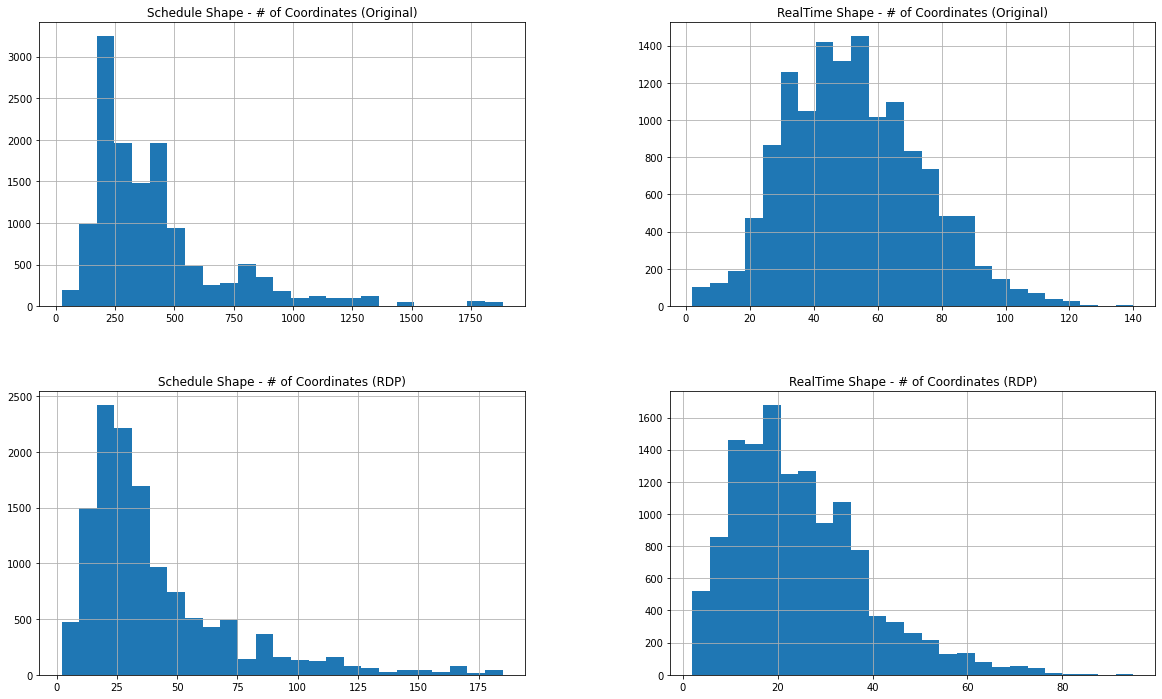

In [109]:
shape_len_hist = pd.DataFrame()
shape_len_hist["Schedule Shape - # of Coordinates (Original)"] = data_set['sch_shape_len']
shape_len_hist["RealTime Shape - # of Coordinates (Original)"] = data_set['rt_shape_len']
shape_len_hist["Schedule Shape - # of Coordinates (RDP)"] = data_set_rdp['sch_shape_len']
shape_len_hist["RealTime Shape - # of Coordinates (RDP)"] = data_set_rdp['rt_shape_len']
rdp_hist = shape_len_hist.hist( bins=25, figsize=(20,12))

In [ ]:
data_set_sim = data_set_rdp.copy()

for idx, row in data_set_sim.iterrows():
    rt = np.stack(row['rt_shape'], axis=0)
    sh = np.stack(row['sch_shape'], axis=0)
    
    data_set_sim.at[idx, 'PCM'] = similaritymeasures.pcm(rt, sh)
    data_set_sim.at[idx, 'Frechet_Dist'] = similaritymeasures.frechet_dist(rt, sh)
    data_set_sim.at[idx, 'Area_bt_Curves'] = similaritymeasures.area_between_two_curves(rt, sh)
#    data_set_sim.at[idx, 'Curve_length'] = similaritymeasures.curve_length_measure(rt, sh)
#    data_set_sim.at[idx, 'Dynamic_Time_Warp'] = similaritymeasures.dtw(rt, sh)
#    data_set_sim.at[idx, 'Mean_Abs_Error'] = similaritymeasures.mae(rt, sh)
#    data_set_sim.at[idx, 'Mean_Sq_Error'] = similaritymeasures.mse(rt, sh)

data_set_sim.to_parquet('data\data_set_sim.parquet', compression='gzip')

data_set_sim.head()

In [27]:
index_to_plot = 1582

map = folium.Map(location=[40,-75.154839], zoom_start= 12)
  
folium.PolyLine(data_set.iloc[index_to_plot]['rt_shape'], color = 'blue', popup = 'Schedule shape', weight=7, opacity=0.6).add_to(map) 
folium.PolyLine(rdp(data_set.iloc[index_to_plot]['rt_shape'], epsilon=0.0001), color = 'red', popup = 'RT shape', weight=7, opacity=0.6).add_to(map) 

map

In [26]:
def cleaning_anal(data):
    
    for index, row in data.iterrows():
        
        sch_ln = LineString(row['sch_shape'])
        rt_ln = LineString(row['rt_shape'])
        
        # length ratios of RT to scheduled shape
        sch_len = LineString(sch_ln).length
        rt_len = LineString(rt_ln).length
        
        data.at[index, 'rt_sch_len_ratio'] = round(rt_len/sch_len, 3)
        
        # max deviation distance
        h_dist = rt_ln.hausdorff_distance(sch_ln)
                
        data.at[index, 'max_detour_dist'] = h_dist

    return data

In [ ]:
data_set_cl = cleaning_anal(data_set)
data_set_cl = data_set_cl.sort_values(by=['max_detour_dist'])
#pd.concat([data_set_cl.head(3), data_set_cl.tail(3)])

data_set_cl.to_parquet('data\data_set_cl.parquet', compression='gzip')

In [ ]:
index_to_plot = 149

map = folium.Map(location=[40,-75.154839], zoom_start= 12)
  
folium.PolyLine(data_set_cl.iloc[index_to_plot]['sch_shape'], color = 'blue', popup = 'Schedule shape', weight=7, opacity=0.6).add_to(map) 
folium.PolyLine(data_set_cl.iloc[index_to_plot]['rt_shape'], color = 'red', popup = 'RT shape', weight=7, opacity=0.6).add_to(map) 

map

In [ ]:
#def cleaning_anal(data):
#    
#    for index, row in data.iterrows():
#        
#        # length ratios of RT to scheduled shape
#        sch_shape = row['sch_shape']
#        rt_shape = row['rt_shape']
#        
#        geod = Geod(ellps = "WGS84")
#        sch_len = geod.geometry_length(LineString(sch_shape))
#        rt_len = geod.geometry_length(LineString(rt_shape))
#        
#        data.at[index, 'rt_sch_len_ratio'] = round(rt_len/sch_len, 3)
#        
#        # max deviation distance
#        max_dist = 0.
#        for rt_pt in rt_shape:
#            
#            min_dist = float('inf')
#            for sch_pt in sch_shape:
#                _,_,dist = geod.inv(rt_pt[1], rt_pt[0], sch_pt[1], sch_pt[0])
#                if dist < min_dist:
#                    min_dist = dist
#            
#            if min_dist > max_dist:
#                max_dist = min_dist
#                
#        data.at[index, 'max_detour_dist_km'] = max_dist
#
#    return data

23.39863473717475 0.6507707802015316 13.950295247977273 7.482349188241031 40.46574407334172 0.31078497368480357 0.1469640220512024


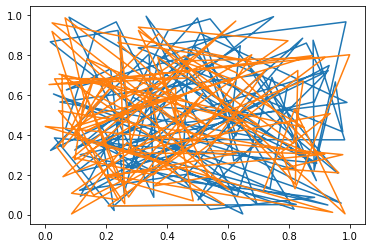

In [86]:
import matplotlib.pyplot as plt

# Generate random experimental data
x = np.random.random(100)
y = np.random.random(100)
exp_data = np.zeros((100, 2))
exp_data[:, 0] = x
exp_data[:, 1] = y

# Generate random numerical data
x = np.random.random(100)
y = np.random.random(100)
num_data = np.zeros((100, 2))
num_data[:, 0] = x
num_data[:, 1] = y

# quantify the difference between the two curves using PCM
pcm = similaritymeasures.pcm(exp_data, num_data)

# quantify the difference between the two curves using
# Discrete Frechet distance
df = similaritymeasures.frechet_dist(exp_data, num_data)

# quantify the difference between the two curves using
# area between two curves
area = similaritymeasures.area_between_two_curves(exp_data, num_data)

# quantify the difference between the two curves using
# Curve Length based similarity measure
cl = similaritymeasures.curve_length_measure(exp_data, num_data)

# quantify the difference between the two curves using
# Dynamic Time Warping distance
dtw, d = similaritymeasures.dtw(exp_data, num_data)

# mean absolute error
mae = similaritymeasures.mae(exp_data, num_data)

# mean squared error
mse = similaritymeasures.mse(exp_data, num_data)

# print the results
print(pcm, df, area, cl, dtw, mae, mse)

# plot the data
plt.figure()
plt.plot(exp_data[:, 0], exp_data[:, 1])
plt.plot(num_data[:, 0], num_data[:, 1])
plt.show()

In [92]:
np.stack(data_set_rdp.iloc[0]['rt_shape'], axis=0)

array([[ 40.024288, -75.077385],
       [ 40.028606, -75.074188],
       [ 40.034023, -75.071594],
       [ 40.035507, -75.067719],
       [ 40.036743, -75.062912],
       [ 40.038944, -75.059822],
       [ 40.045601, -75.053139],
       [ 40.053188, -75.049515],
       [ 40.058826, -75.044281],
       [ 40.066692, -75.040619],
       [ 40.073349, -75.035606],
       [ 40.081871, -75.027611],
       [ 40.094166, -75.015274],
       [ 40.098427, -75.010292],
       [ 40.103653, -75.002968],
       [ 40.115944, -74.985046],
       [ 40.121223, -74.976974],
       [ 40.122105, -74.977081],
       [ 40.131924, -74.9757  ],
       [ 40.136021, -74.971573],
       [ 40.136871, -74.969116],
       [ 40.13657 , -74.965034],
       [ 40.137421, -74.96389 ],
       [ 40.138412, -74.959091],
       [ 40.137562, -74.957741],
       [ 40.135773, -74.955467],
       [ 40.136517, -74.952515],
       [ 40.138111, -74.953438]])